In [ ]:
# importing liberaries
import yfinance as yf
import pandas as pd

In [3]:
bhavcopy_path = '/Users/somrajbharadwaj/nse bhavcopy (1).csv'

df_bhav = pd.read_csv(bhavcopy_path)
df_bhav.head()

,SYMBOL,NAME OF COMPANY,SERIES,DATE OF LISTING,PAID UP VALUE,MARKET LOT,ISIN NUMBER,FACE VALUE
0,20MICRONS,20 Microns Limited,EQ,06-OCT-2008,5,1,INE144J01027,5
1,21STCENMGM,21st Century Management Services Limited,BE,03-MAY-1995,10,1,INE253B01015,10
2,360ONE,360 ONE WAM LIMITED,EQ,19-SEP-2019,1,1,INE466L01038,1
3,3IINFOLTD,3i Infotech Limited,EQ,22-OCT-2021,10,1,INE748C01038,10
4,3MINDIA,3M India Limited,EQ,13-AUG-2004,10,1,INE470A01017,10


In [4]:
df_bhav.columns = df_bhav.columns.str.strip()

df_eq = df_bhav[df_bhav['SERIES'] == 'EQ']

symbols = df_eq['SYMBOL'].unique().tolist()
symbols = [symbol + ".NS" for symbol in symbols]

print("Total EQ stocks found:", len(symbols))
print("Example tickers:", symbols[:5])

Total EQ stocks found: 1797
Example tickers: ['20MICRONS.NS', '360ONE.NS', '3IINFOLTD.NS', '3MINDIA.NS', '5PAISA.NS']


In [5]:
import os
import time
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import yfinance as yf

# Silence yfinance noise
logging.getLogger("yfinance").setLevel(logging.CRITICAL)

# Output folder in Drive
output_dir = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset"
os.makedirs(output_dir, exist_ok=True)

START_DATE = "2006-01-01"
END_DATE = "2025-10-31"

def download_stock(symbol: str) -> str:
    try:
        filename = f"{symbol.replace('.NS', '')}_2006_2025.csv"
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            return f"Already exists: {symbol}"

        # Single-ticker download
        data = yf.download(
            symbol,
            start=START_DATE,
            end=END_DATE,
            progress=False,
            auto_adjust=False,
            threads=False,
            interval="1d"
        )

        if data is None or data.empty:
            return f"No data: {symbol}"

        data.reset_index(inplace=True)
        data.to_csv(filepath, index=False)
        return f"Downloaded: {symbol} ({len(data)} rows)"

    except Exception as e:
        return f"Failed {symbol}: {e}"

# Try with fewer threads first
max_threads = 20  # start low, you can increase to 5 later

print("Starting multithreaded download...")

success = no_data = failed = 0

with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = {executor.submit(download_stock, symbol): symbol for symbol in symbols}

    from tqdm.auto import tqdm
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
        result = future.result()
        print(result)

        if result.startswith("Downloaded"):
            success += 1
        elif result.startswith("No data"):
            no_data += 1
        elif result.startswith("Failed"):
            failed += 1



print("\nSummary:")
print("Downloaded:", success)
print("No data:", no_data)
print("Failed:", failed)
print("Total tried:", len(symbols))


Starting multithreaded download...


Downloading:   0%|          | 0/1797 [00:00<?, ?it/s]

Already exists: MENONBE.NS
Already exists: ORIENTTECH.NS
Already exists: LAURUSLABS.NS
Already exists: ASKAUTOLTD.NS
Already exists: MEGASTAR.NS
Already exists: FILATEX.NS
Already exists: ORIENTPPR.NS
Already exists: LATENTVIEW.NS
Already exists: ASIANTILES.NS
Already exists: MEDPLUS.NS
Already exists: FIEMIND.NS
Already exists: ORIENTHOT.NS
Already exists: LASA.NS
Already exists: ASIANPAINT.NS
Already exists: MEDICO.NS
Already exists: FIBERWEB.NS
Already exists: ORIENTELEC.NS
Already exists: LAOPALA.NS
Already exists: ASIANENE.NS
Already exists: MEDICAMEQ.NS
Already exists: FEDFINA.NS
Already exists: ORIENTCER.NS
Already exists: LANDMARK.NS
Already exists: ASHOKLEY.NS
Already exists: MEDIASSIST.NS
Already exists: FEDERALBNK.NS
Already exists: ORIENTCEM.NS
Already exists: LANCORHOL.NS
Already exists: ASHOKAMET.NS
Already exists: MEDANTA.NS
Already exists: FDC.NS
Already exists: ORIENTBELL.NS
Already exists: LALPATHLAB.NS
Already exists: ASHOKA.NS
Already exists: MCX.NS
Already exists: 

In [ ]:
import os
import pandas as pd

#  Settings 
data_dir = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset"
output_path = os.path.join(data_dir, "top_250_by_value.csv")

# Make sure these bluechip names are in the final list if possible
must_include = [
    "RELIANCE", "TCS", "INFY", "ICICIBANK","BHEL", "TATAMOTORS", "LT", "SBIN", "BAJFINANCE"
]

value_records = []

# === Step 1: Scan all CSV files and compute total traded value per symbol ===
for fname in os.listdir(data_dir):
    # Skip the aggregated output file and anything that isn't a CSV
    if not fname.endswith(".csv") or "top_250" in fname:
        continue

    file_path = os.path.join(data_dir, fname)

    try:
        frame = pd.read_csv(file_path)

        # Some NSE files have a duplicated header row at index 0
        if not frame.empty:
            frame = frame.iloc[1:].reset_index(drop=True)

        # Convert to numeric (invalid values -> NaN)
        frame["Volume"] = pd.to_numeric(frame["Volume"], errors="coerce")
        frame["Close"] = pd.to_numeric(frame["Close"], errors="coerce")

        # Total traded value for entire file
        traded_value = (frame["Volume"] * frame["Close"]).sum(skipna=True)

        # Extract symbol from filename 
        symbol_name = fname.split("_")[0]
        value_records.append((symbol_name, traded_value))

    except Exception as exc:
        print(f"Skipping {fname}: {exc}")

# Build table, aggregate per symbol, sort by traded value 
value_df = pd.DataFrame(value_records, columns=["Symbol", "TotalTradedValue"])

# If the same symbol appears in multiple files, combine them
value_df = (
    value_df
    .groupby("Symbol", as_index=False)["TotalTradedValue"]
    .sum()
    .sort_values(by="TotalTradedValue", ascending=False)
    .reset_index(drop=True)
)

# Build final list of 250 symbols (value-based + must-include) 
available_symbols = set(value_df["Symbol"])

# Warn about must_include symbols that aren't present
missing_must = [s for s in must_include if s not in available_symbols]
if missing_must:
    print(
        "WARNING - these must_include symbols are missing from value_df and "
        "cannot be included:",
        missing_must
    )

# Keep only those must_include that actually exist
must_include_present = [s for s in must_include if s in available_symbols]

# First: straight top 250 by traded value
core_top_250 = value_df["Symbol"].head(250).tolist()

# Merge required bluechips + core list, remove duplicates while preserving order
ordered_candidates = must_include_present + core_top_250
seen = set()
final_symbol_list = []

for sym in ordered_candidates:
    if sym not in seen:
        seen.add(sym)
        final_symbol_list.append(sym)

# Ensure we have exactly 250 symbols (or fewer if not enough exist)
final_symbol_list = final_symbol_list[:250]

#  Filter to final symbols, keep that order, and save 
filtered_df = value_df[value_df["Symbol"].isin(final_symbol_list)].copy()

# Enforce the desired order using a Categorical
filtered_df["Symbol"] = pd.Categorical(
    filtered_df["Symbol"],
    categories=final_symbol_list,
    ordered=True,
)
filtered_df = filtered_df.sort_values("Symbol").reset_index(drop=True)

filtered_df.to_csv(output_path, index=False)

print(f"Final Top 250 saved to: {output_path}")
print("Top 10 preview:", filtered_df["Symbol"].head(10).tolist())


Final Top 250 saved to: /Users/somrajbharadwaj/project/final_data_science/venv/dataset/top_250_by_value.csv
Top 10 preview: ['RELIANCE', 'TCS', 'INFY', 'ICICIBANK', 'BHEL', 'TATAMOTORS', 'LT', 'SBIN', 'BAJFINANCE', 'top250']


In [51]:
import os
import pandas as pd

# Path to stock data and final stock list
data_dir = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset"
final_list_path = os.path.join(data_dir, "top_250_by_value.csv")

# Load the final selected stocks
final_stocks_df = pd.read_csv(final_list_path)
selected_symbols = final_stocks_df["Symbol"].tolist()

# List to hold all DataFrames
merged_data = []

# Loop through each selected stock and clean its data
for symbol in selected_symbols:
    file_path = os.path.join(data_dir, f"{symbol}_2006_2025.csv")

    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)

            # Drop header/extra row if needed
            df = df.drop(index=0).reset_index(drop=True)

            # Convert types
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Drop rows with missing Date or Close
            df.dropna(subset=["Date", "Close"], inplace=True)

            # Add stock symbol
            df["Stock"] = symbol

            # Append to list
            merged_data.append(df)
        except Exception as e:
            print(f"Skipping {symbol}: {e}")
    else:
        print(f"File not found for {symbol}")

# Combine into one DataFrame
if merged_data:
    final_df = pd.concat(merged_data, ignore_index=True)
    output_path = os.path.join(data_dir, "merged_top250_clean.csv")
    final_df.to_csv(output_path, index=False)
    print(f"Merged dataset saved to: {output_path}")
    print("Shape:", final_df.shape)
else:
    print("No data merged. Check your paths and files.")

File not found for top250
File not found for merged
Merged dataset saved to: /Users/somrajbharadwaj/project/final_data_science/venv/dataset/merged_top250_clean.csv
Shape: (1060304, 110)


In [52]:
import pandas as pd

# Load the uploaded merged dataset
file_path = '/Users/somrajbharadwaj/project/final_data_science/venv/dataset/merged_top250_clean.csv'
df = pd.read_csv(file_path)

# Show basic info and check for missing values
df_info = df.info()
missing_summary = df.isnull().sum()

# Display first few rows
df_preview = df.head()

df_info, missing_summary, df_preview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060304 entries, 0 to 1060303
Columns: 110 entries, Date to Volume.17
dtypes: float64(108), object(2)
memory usage: 889.8+ MB


(None,
 Date               0
 Adj Close          0
 Close              0
 High               0
 Low                0
               ...   
 Close.17     1058062
 High.17      1058062
 Low.17       1058062
 Open.17      1058062
 Volume.17    1058062
 Length: 110, dtype: int64,
          Date  Adj Close      Close       High        Low       Open  \
 0  2006-01-02  55.198132  64.111961  64.408295  63.562130  63.765640   
 1  2006-01-03  56.559868  65.693604  65.972084  63.979858  64.229774   
 2  2006-01-04  57.165421  66.396950  66.836098  65.693604  65.765007   
 3  2006-01-05  56.664391  65.814995  66.836098  65.693604  66.621880   
 4  2006-01-06  56.602905  65.743584  66.511200  65.200897  65.814995   
 
        Volume     Stock  Adj Close.1  Adj Close.2  ...  High.16  Low.16  \
 0  51281633.0  RELIANCE          NaN          NaN  ...      NaN     NaN   
 1  68687753.0  RELIANCE          NaN          NaN  ...      NaN     NaN   
 2  60512596.0  RELIANCE          NaN          NaN  ...

In [53]:
import pandas as pd

# Load merged dataset
merged_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/merged_top250_clean.csv"
df = pd.read_csv(merged_path)

# Drop ALL unnecessary columns ending with .1, .2, .3, ...
df = df.loc[:, ~df.columns.str.contains(r"\.\d+$")]

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort data
df = df.sort_values(by=["Stock", "Date"]).reset_index(drop=True)

# Missing value summary
print("Missing values after cleaning:\n", df.isnull().sum())

# Save final cleaned file
cleaned_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned_final.csv"
df.to_csv(cleaned_path, index=False)
print("Cleaned dataset saved to:", cleaned_path)


Missing values after cleaning:
 Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Stock        0
dtype: int64
Cleaned dataset saved to: /Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned_final.csv


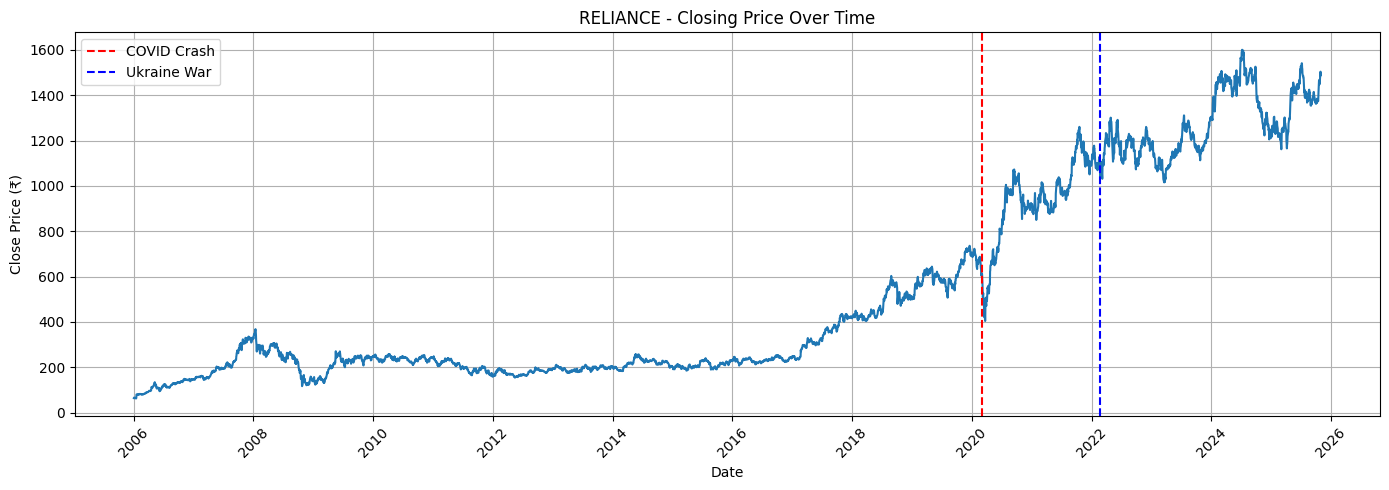

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned_final.csv")

# Filter for a specific stock
sample_stock =("RELIANCE")
sample_df = df[df["Stock"] == sample_stock].sort_values("Date")

# Ensure 'Date' column is in datetime format
sample_df["Date"] = pd.to_datetime(sample_df["Date"])

# Set a clean plot style
plt.style.use('default')

# Create the plot
plt.figure(figsize=(14, 5))
sns.lineplot(data=sample_df, x="Date", y="Close")

plt.title(f"{sample_stock} - Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (₹)")
plt.grid(True)

# Format X-axis to show ticks every 2 years
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Annotate major market events

plt.axvline(pd.to_datetime("2020-03-01"), color='red', linestyle='--', label='COVID Crash')
plt.axvline(pd.to_datetime("2022-02-24"), color='blue', linestyle='--', label='Ukraine War')

# Add legend
plt.legend()

# Tight layout and display
plt.tight_layout()
plt.show()


In [8]:
import ta
import matplotlib.pyplot as plt

# Load your preprocessed dataset
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned_final.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Container for all indicator-enhanced data
enhanced_data = []

# Loop through each stock individually
for stock in df["Stock"].unique():
    stock_df = df[df["Stock"] == stock].copy()
    stock_df = stock_df.sort_values("Date")

    # Add technical indicators using `ta`
    stock_df["SMA_14"] = ta.trend.sma_indicator(stock_df["Close"], window=14)
    stock_df["EMA_14"] = ta.trend.ema_indicator(stock_df["Close"], window=14)
    stock_df["RSI_14"] = ta.momentum.rsi(stock_df["Close"], window=14)
    macd = ta.trend.macd(stock_df["Close"])
    stock_df["MACD"] = macd
    bb = ta.volatility.BollingerBands(close=stock_df["Close"], window=20, window_dev=2)
    stock_df["BB_High"] = bb.bollinger_hband()
    stock_df["BB_Low"] = bb.bollinger_lband()
    stock_df["ATR_14"] = ta.volatility.average_true_range(stock_df["High"], stock_df["Low"], stock_df["Close"], window=14)
    stock_df["Volume_SMA_14"] = ta.trend.sma_indicator(stock_df["Volume"], window=14)

    # Drop rows with NaNs caused by rolling indicators
    stock_df.dropna(inplace=True)

    # Append processed stock data
    enhanced_data.append(stock_df)

# Combine all processed stock data
df_final = pd.concat(enhanced_data, ignore_index=True)

# Save to file
output_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_with_indicators.csv"
df_final.to_csv(output_path, index=False)

print("Technical indicators added and saved to:", output_path)
print("Final dataset shape:", df_final.shape)
df_final.head()

Technical indicators added and saved to: /Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_with_indicators.csv
Final dataset shape: (1054104, 16)


,Date,Adj Close,Close,High,Low,Open,Volume,Stock,SMA_14,EMA_14,RSI_14,MACD,BB_High,BB_Low,ATR_14,Volume_SMA_14
0,2006-02-08,80.669418,88.966522,91.145378,88.243866,88.970154,800163.0,ABB,87.781246,86.432615,69.932397,4.458877,98.526256,68.407168,3.144599,778290.071429
1,2006-02-10,79.872566,88.087715,89.623810,86.791290,89.623810,360232.0,ABB,88.622182,86.653295,66.388441,4.205653,98.629246,69.788890,3.122307,765349.142857
2,2006-02-13,81.933830,90.360992,91.330582,88.134918,88.134918,1121248.0,ABB,89.235246,87.147655,70.546498,4.140674,98.759028,71.400200,3.130919,799491.142857
3,2006-02-14,81.942047,90.370071,92.238441,86.718658,86.718658,643475.0,ABB,89.759859,87.577311,70.562161,4.043302,98.547097,73.393712,3.301552,777596.571429
4,2006-02-15,81.833397,90.250237,91.982430,89.375053,90.313782,648729.0,ABB,89.766344,87.933701,70.032775,3.911376,98.084481,75.549486,3.251968,720325.571429


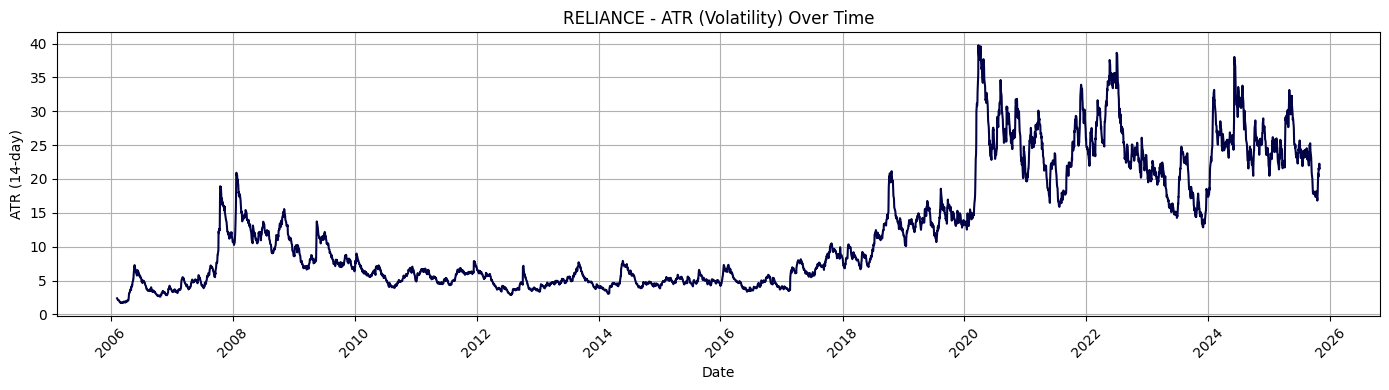

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


# Load the cleaned dataset
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_with_indicators.csv")

# Ensure Date is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Filter a Sample Stock
sample_stock = "RELIANCE"
sample_df = df[df["Stock"] == sample_stock].sort_values("Date")  

# 6. Plot ATR Over Time (Volatility)

# Make sure ATR_14 column is present from feature engineering
if "ATR_14" in sample_df.columns:
    plt.figure(figsize=(14, 4))
    sns.lineplot(data=sample_df, x="Date", y="ATR_14", color="#020247") 
    plt.title(f"{sample_stock} - ATR (Volatility) Over Time")
    plt.xlabel("Date")
    plt.ylabel("ATR (14-day)")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("ATR_14 column not found. Make sure technical indicators are computed.")

In [10]:
import pandas as pd

# Load the dataset with technical indicators
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_with_indicators.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Store train/test splits
train_list = []
test_list = []

# Split 80/20 for each stock chronologically
for stock in df["Stock"].unique():
    stock_df = df[df["Stock"] == stock].sort_values("Date").reset_index(drop=True)

    # Define the 80% cutoff index
    split_idx = int(len(stock_df) * 0.8)

    # Split into train and test
    train_df = stock_df.iloc[:split_idx].copy()
    test_df = stock_df.iloc[split_idx:].copy()

    train_list.append(train_df)
    test_list.append(test_df)

# Combine all stocks’ splits into final DataFrames
train_data = pd.concat(train_list, ignore_index=True)
test_data = pd.concat(test_list, ignore_index=True)

# Save to file for modeling use
train_data.to_csv("/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv", index=False)
test_data.to_csv("/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv", index=False)

print("Data split 80/20 and saved.")
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)


Data split 80/20 and saved.
Train shape: (843117, 16)
Test shape: (210987, 16)


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load training and testing datasets
train = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv")
test = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv")

# Ensure 'Date' column is in datetime format
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

# Define technical indicator features
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Create the prediction target column
train["Target"] = train.groupby("Stock")["Close"].shift(-1)
test["Target"] = test.groupby("Stock")["Close"].shift(-1)

# Drop rows with missing values
train.dropna(subset=features + ["Target"], inplace=True)
test.dropna(subset=features + ["Target"], inplace=True)

# Feature matrix, target variable
X_train, y_train = train[features], train["Target"]
X_test, y_test = test[features], test["Target"]


# Training Random Forest
model = RandomForestRegressor(n_estimators=100,
                              random_state=42)
model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

RMSE: 3420.91
MAE: 292.73
R² Score: 0.9116


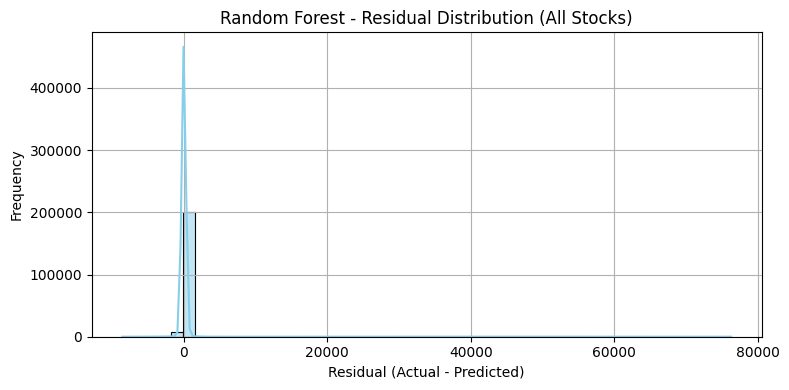

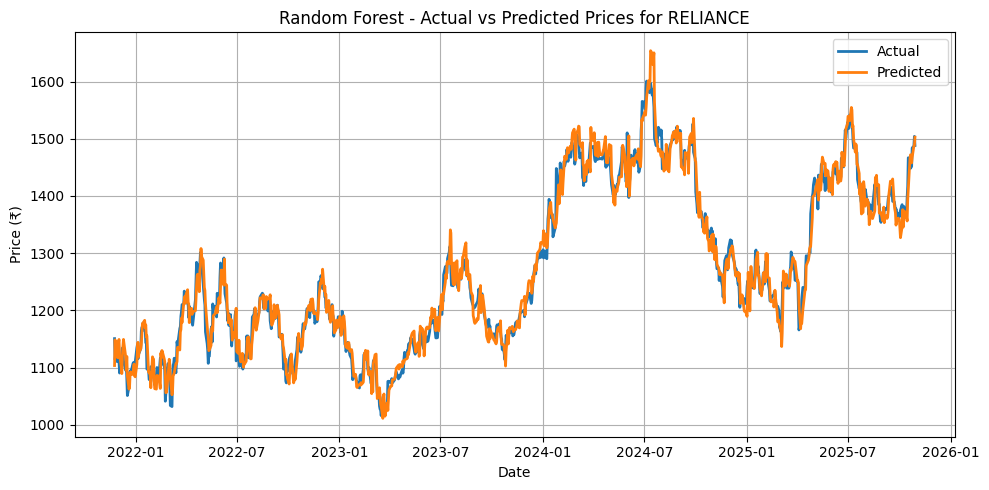

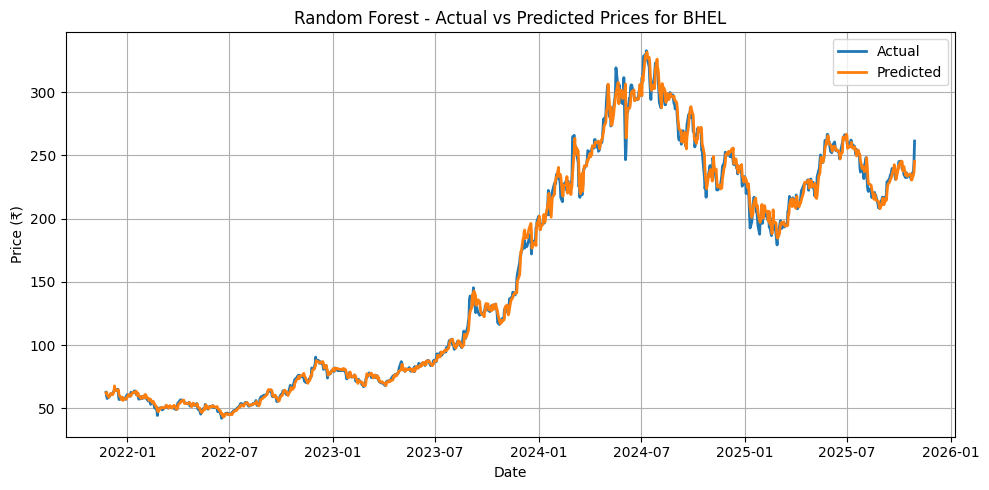

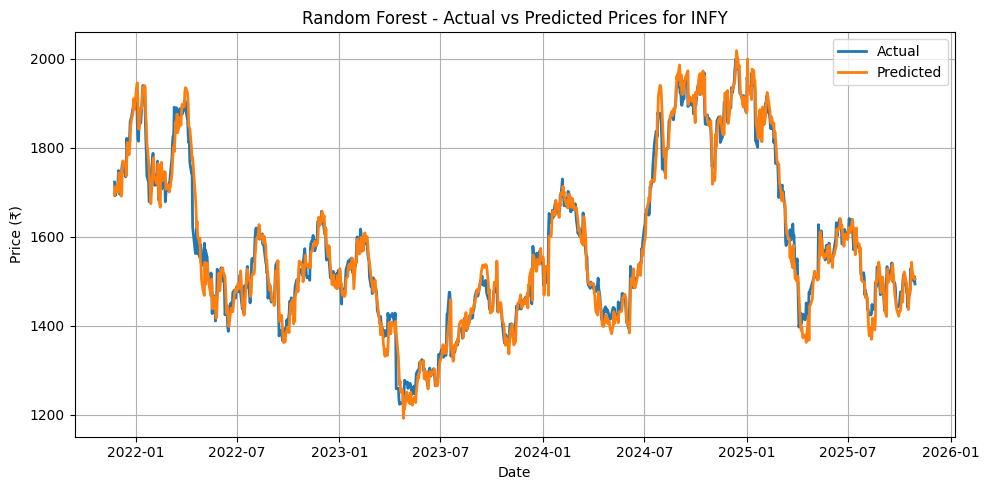

In [60]:

# Make predictions
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)


print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Save metrics for model comparison
rf_rmse = rmse
rf_mae = mae
rf_r2 = r2

# Residual distribution
residuals = y_test - preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True, color='skyblue')
plt.title("Random Forest - Residual Distribution (All Stocks)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Function to visualize actual vs predicted for individual stocks
def plot_stock_predictions(stock_symbol, model, test_df, feature_cols):
    stock_data = test_df[test_df["Stock"] == stock_symbol].copy()
    stock_data.dropna(subset=feature_cols + ["Target"], inplace=True)

    if stock_data.empty:
        print(f"No valid data found for {stock_symbol}")
        return

    dates = stock_data["Date"]
    actual = stock_data["Target"]
    predicted = model.predict(stock_data[feature_cols])

    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label='Actual', linewidth=2)
    plt.plot(dates, predicted, label='Predicted', linewidth=2)
    plt.title(f"Random Forest - Actual vs Predicted Prices for {stock_symbol}")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predictions for selected companies
plot_stock_predictions("RELIANCE", model, test, features)
plot_stock_predictions("BHEL", model, test, features)
plot_stock_predictions("INFY", model, test, features)



        Date  Predicted_Close
0 2025-10-31      1509.010828
1 2025-11-03      1520.313246
2 2025-11-04      1528.253424
3 2025-11-05      1544.833865
4 2025-11-06      1548.543624

Saved: rf_next_14_days_forecast.csv


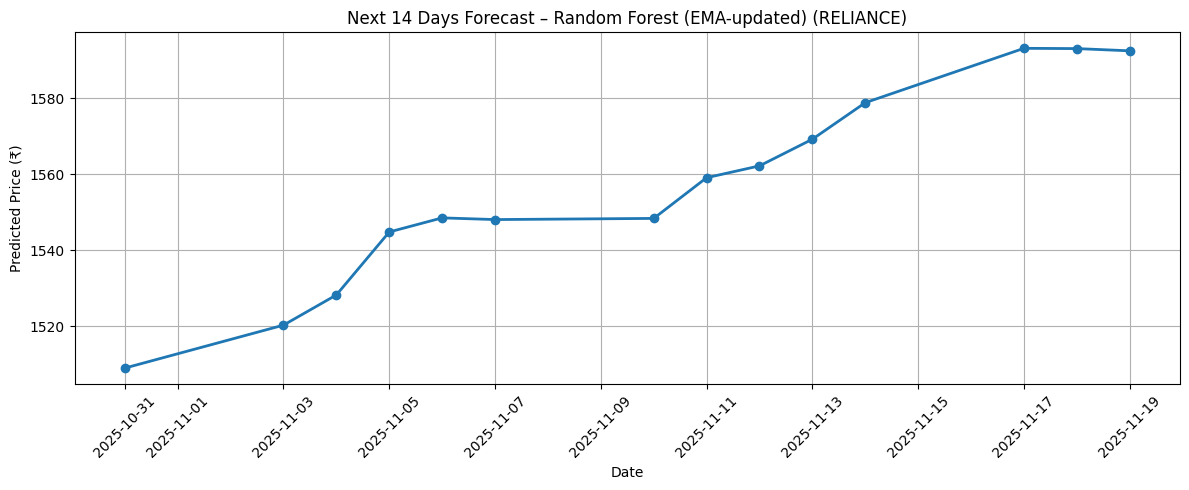

In [ ]:
# NEXT 14 DAYS FORECAST 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load train/test data

train_path = "/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv"
test_path  = "/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

train["Date"] = pd.to_datetime(train["Date"])
test["Date"]  = pd.to_datetime(test["Date"])

# Features (must match training)

features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Create next-day target (supervised learning)

train["Target"] = train.groupby("Stock")["Close"].shift(-1)
test["Target"]  = test.groupby("Stock")["Close"].shift(-1)  # optional (not used for future forecast)

# drop null data
train = train.dropna(subset=features + ["Target"]).copy()
test  = test.dropna(subset=features).copy()  # Target not required for future forecast

X_train = train[features]
y_train = train["Target"]

#  Train Random Forest

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

#  Pick stock & get last known feature row from that stock

stock_symbol = "RELIANCE"   # select any share name 

stock_df = test[test["Stock"] == stock_symbol].sort_values("Date").copy()
if stock_df.empty:
    raise ValueError(f"No rows found for stock_symbol='{stock_symbol}'. Check test['Stock'].unique().")

last_row = stock_df.iloc[-1]
last_date = last_row["Date"]

# Create next 14 business days (trading-day approximation)

future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=14)

#  Recursive forecast with EMA update

alpha = 2 / (14 + 1)  # EMA smoothing factor

current_features = last_row[features].copy()
ema = float(current_features["EMA_14"])

future_predictions = []

for d in future_dates:
    # keep as DataFrame with proper feature names (removes sklearn warning)
    X_future = pd.DataFrame([current_features], columns=features)

    next_close = float(model.predict(X_future)[0])

    future_predictions.append({
        "Date": d,
        "Predicted_Close": next_close
    })

    # Update EMA using predicted close (makes forecast non-flat)
    ema = alpha * next_close + (1 - alpha) * ema
    current_features["EMA_14"] = ema

# Forecast DataFrame and save

future_df = pd.DataFrame(future_predictions)
future_df.to_csv("rf_next_14_days_forecast.csv", index=False)

print(future_df.head())
print("\nSaved: rf_next_14_days_forecast.csv")

#  Plot: Next 14 predicted only

plt.figure(figsize=(12, 5))
plt.plot(future_df["Date"], future_df["Predicted_Close"], marker="o", linewidth=2)
plt.title(f"Next 14 Days Forecast – Random Forest (EMA-updated) ({stock_symbol})")
plt.xlabel("Date")
plt.ylabel("Predicted Price (₹)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# Load training data
train = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv")

# Define features and target
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]
train["Target"] = train.groupby("Stock")["Close"].shift(-1)
train.dropna(subset=features + ["Target"], inplace=True)

X_train, y_train = train[features], train["Target"]

# Use time-based CV
tscv = TimeSeriesSplit(n_splits=3)

# Define a reduced search space for speed
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# File to save best model
model_path = "/Users/somrajbharadwaj/project/final_data_science/venv/best_random_forest_model_fast.pkl"

# If saved model exists, load it; else perform tuning and save
if os.path.exists(model_path):
    best_rf_model = joblib.load(model_path)
else:
    search = RandomizedSearchCV(
        estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
        param_distributions=param_dist,
        n_iter=20,
        cv=tscv,
        verbose=2,
        scoring='neg_mean_squared_error',
        random_state=42
    )
    search.fit(X_train, y_train)
    best_rf_model = search.best_estimator_
    joblib.dump(best_rf_model, model_path)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  12.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator


Evaluation for RELIANCE (2021–2025):
RMSE: 22.07
MAE: 16.81
R² Score: 0.9753


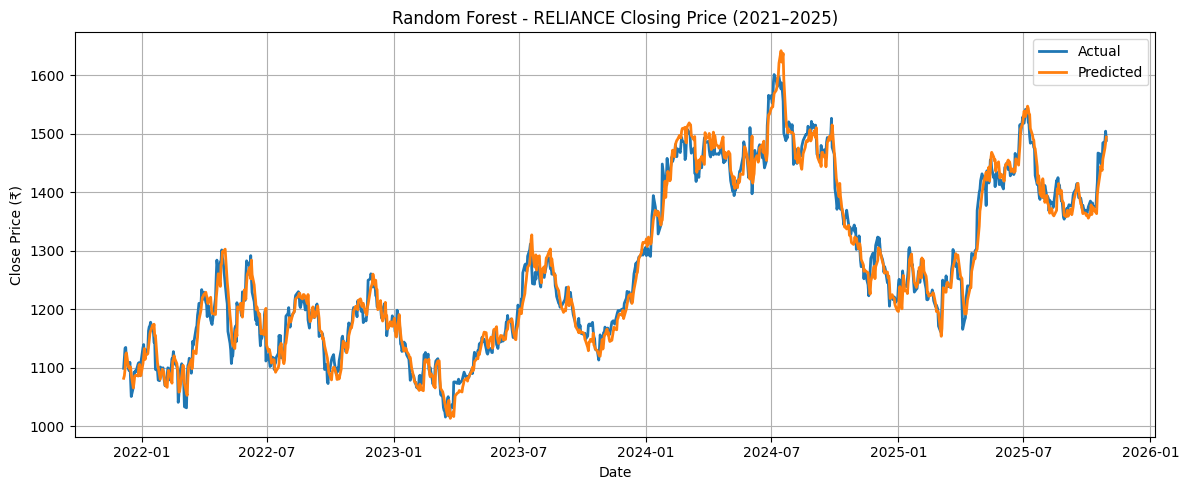


Evaluation for BHEL (2021–2025):
RMSE: 5.54
MAE: 3.54
R² Score: 0.9961


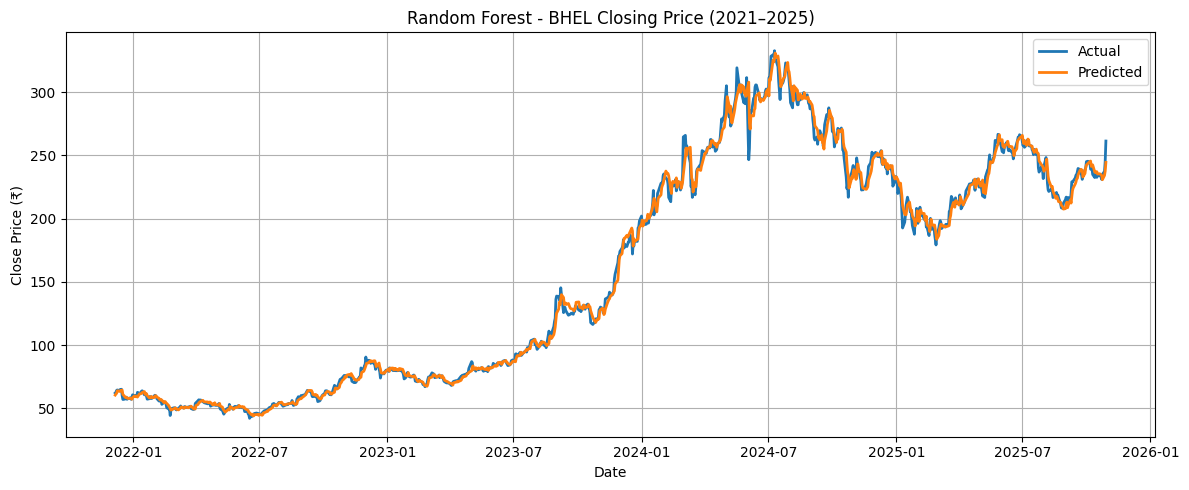


Evaluation for INFY (2021–2025):
RMSE: 32.85
MAE: 24.35
R² Score: 0.9680


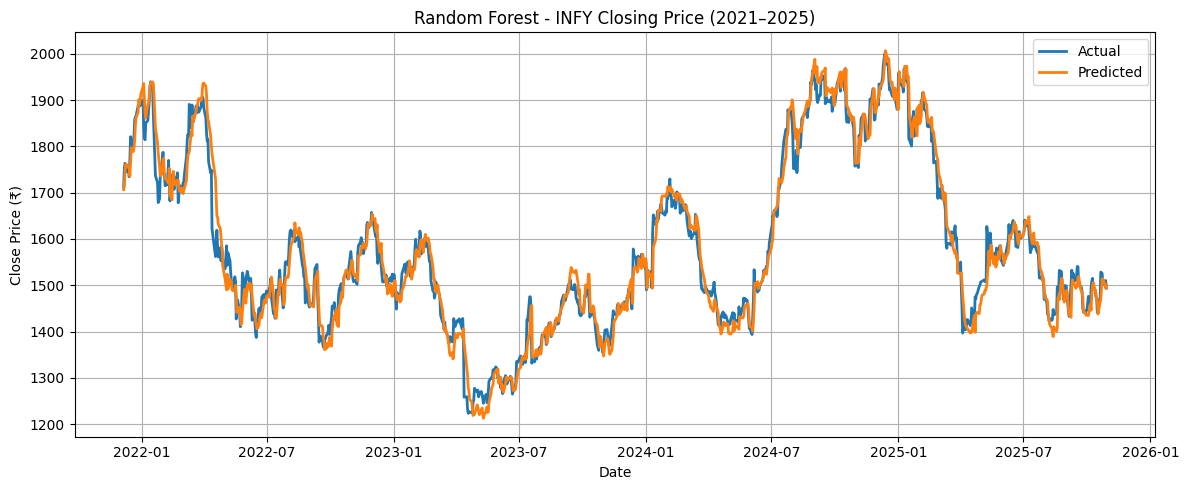


Random Forest evaluation metrics saved to: /Users/somrajbharadwaj/project/final_data_science/venv/random_forest_stock_metrics.csv


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load test dataset
test = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv")
test["Date"] = pd.to_datetime(test["Date"])

# Define features and filter date range
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]
test["Target"] = test.groupby("Stock")["Close"].shift(-1)
test.dropna(subset=features + ["Target"], inplace=True)
test = test[(test["Date"] >= "2021-12-06") & (test["Date"] <= "2025-11-27")]

# Random Forest model
rf_model = joblib.load("/Users/somrajbharadwaj/project/final_data_science/venv/best_random_forest_model_fast.pkl")

# Stocks to evaluate
selected_stocks = ["RELIANCE", "BHEL", "INFY"]

# Store evaluation metrics
rf_metrics_list = []

for stock in selected_stocks:
    stock_df = test[test["Stock"] == stock].copy()

    if stock_df.empty:
        print(f"No data found for {stock}. Skipping...")
        continue

    X = stock_df[features]
    y_actual = stock_df["Target"]
    y_pred = rf_model.predict(X)

    # Evaluation
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    print(f"\nEvaluation for {stock} (2021–2025):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    rf_metrics_list.append({
        "Stock": stock,
        "Model": "Random Forest",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # Plot: Actual vs Predicted
    plt.figure(figsize=(12, 5))
    plt.plot(stock_df["Date"], y_actual, label="Actual", linewidth=2)
    plt.plot(stock_df["Date"], y_pred, label="Predicted", linewidth=2)
    plt.title(f"Random Forest - {stock} Closing Price (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Close Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


    # Save residual plot
    residual_path = f"/Users/somrajbharadwaj/project/final_data_science/venv/rf_residual_plot_{stock.replace('.NS', '')}.png"
    plt.savefig(residual_path)
    plt.show()

# Save evaluation metrics to CSV
rf_metrics_df = pd.DataFrame(rf_metrics_list)
rf_metrics_csv = "/Users/somrajbharadwaj/project/final_data_science/venv/random_forest_stock_metrics.csv"
rf_metrics_df.to_csv(rf_metrics_csv, index=False)

print(f"\nRandom Forest evaluation metrics saved to: {rf_metrics_csv}")


XGBOOST

RMSE: 5236.37
MAE: 590.81
R² Score: 0.7930


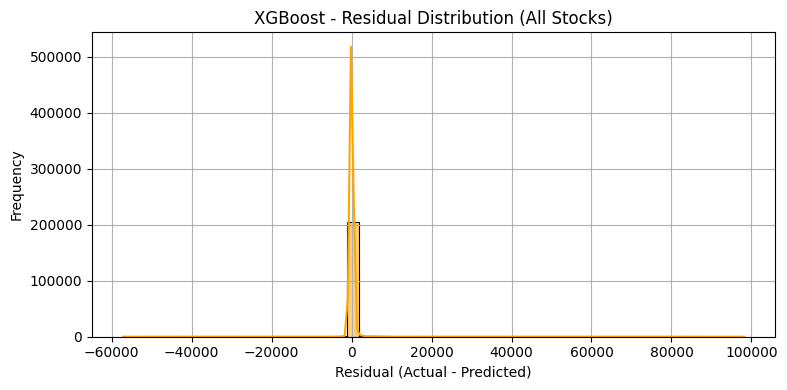

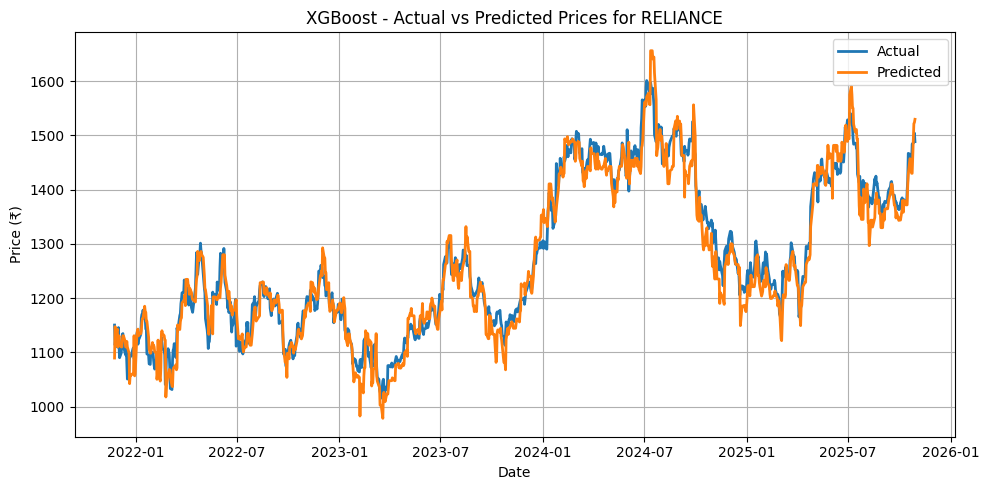

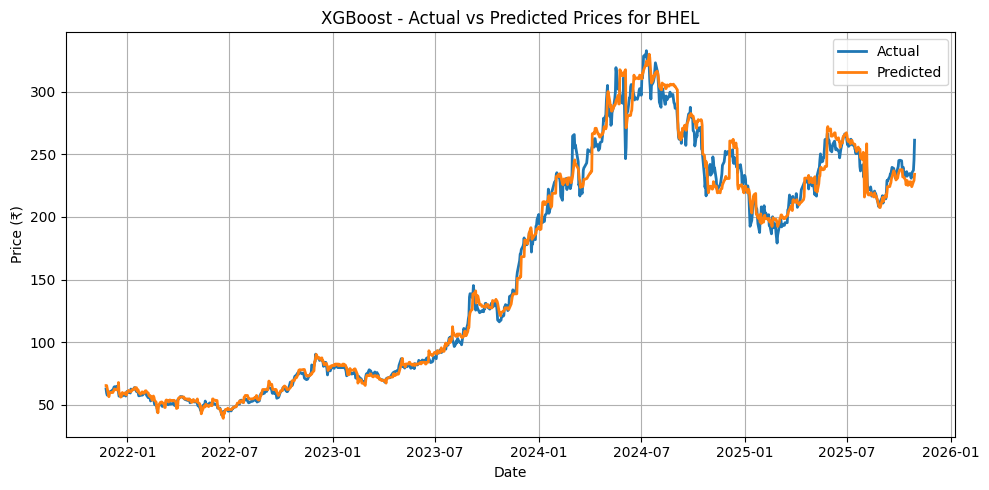

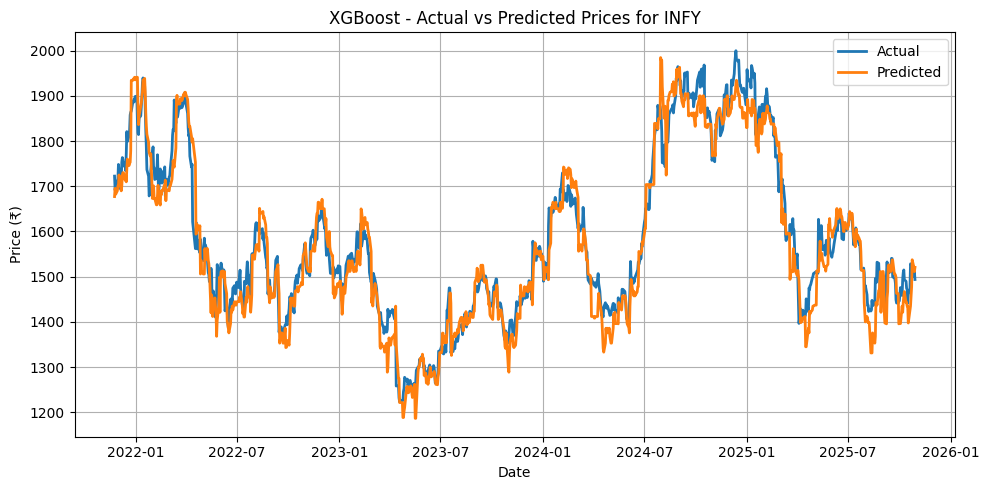

In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load training and testing datasets
train = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv")
test = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv")

# Ensure 'Date' column is in datetime format
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

# Define features used for prediction
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Shift Close to get next-day target
train["Target"] = train.groupby("Stock")["Close"].shift(-1)
test["Target"] = test.groupby("Stock")["Close"].shift(-1)

# Drop rows with missing values
train.dropna(subset=features + ["Target"], inplace=True)
test.dropna(subset=features + ["Target"], inplace=True)

# Model training
X_train, y_train = train[features], train["Target"]
X_test, y_test = test[features], test["Target"]

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predictions
preds = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Save metrics for comparison
xgb_rmse = rmse
xgb_mae = mae
xgb_r2 = r2

# Residual distribution plot
residuals = y_test - preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True, color='orange')
plt.title("XGBoost - Residual Distribution (All Stocks)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Function to plot per-stock predictions
def plot_stock_predictions(stock_symbol, model, test_df, feature_cols):
    stock_data = test_df[test_df["Stock"] == stock_symbol].copy()
    stock_data.dropna(subset=feature_cols + ["Target"], inplace=True)

    if stock_data.empty:
        print(f"No valid data found for {stock_symbol}")
        return

    dates = stock_data["Date"]
    actual = stock_data["Target"]
    predicted = model.predict(stock_data[feature_cols])

    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label='Actual', linewidth=2)
    plt.plot(dates, predicted, label='Predicted', linewidth=2)
    plt.title(f"XGBoost - Actual vs Predicted Prices for {stock_symbol}")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot predictions for selected stocks
plot_stock_predictions("RELIANCE", model, test, features)
plot_stock_predictions("BHEL", model, test, features)
plot_stock_predictions("INFY", model, test, features)

In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# Load training data
train = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv")

# Define features and target
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]
train["Target"] = train.groupby("Stock")["Close"].shift(-1)
train.dropna(subset=features + ["Target"], inplace=True)

X_train, y_train = train[features], train["Target"]
# Use time-based CV
tscv = TimeSeriesSplit(n_splits=3)

# Define a reduced search space for XGBoost
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# File to save best model
xgb_model_path = "/Users/somrajbharadwaj/project/final_data_science/venv/best_xgb_model_fast.pkl"

# If saved model exists, load it; else perform tuning and save
if os.path.exists(xgb_model_path):
    best_xgb_model = joblib.load(xgb_model_path)
else:
    search_xgb = RandomizedSearchCV(
        estimator=XGBRegressor(n_jobs=-1, random_state=42),
        param_distributions=param_dist,
        n_iter=20,
        cv=tscv,
        verbose=2,
        scoring='neg_mean_squared_error',
        random_state=42
    )
    search_xgb.fit(X_train, y_train)
    best_xgb_model = search_xgb.best_estimator_
    joblib.dump(best_xgb_model, xgb_model_path)

"Best XGBoost model ready and saved if needed."


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsamp

'Best XGBoost model ready and saved if needed.'


Evaluation for RELIANCE (2021–2025):
RMSE: 48.30
MAE: 38.86
R² Score: 0.8814


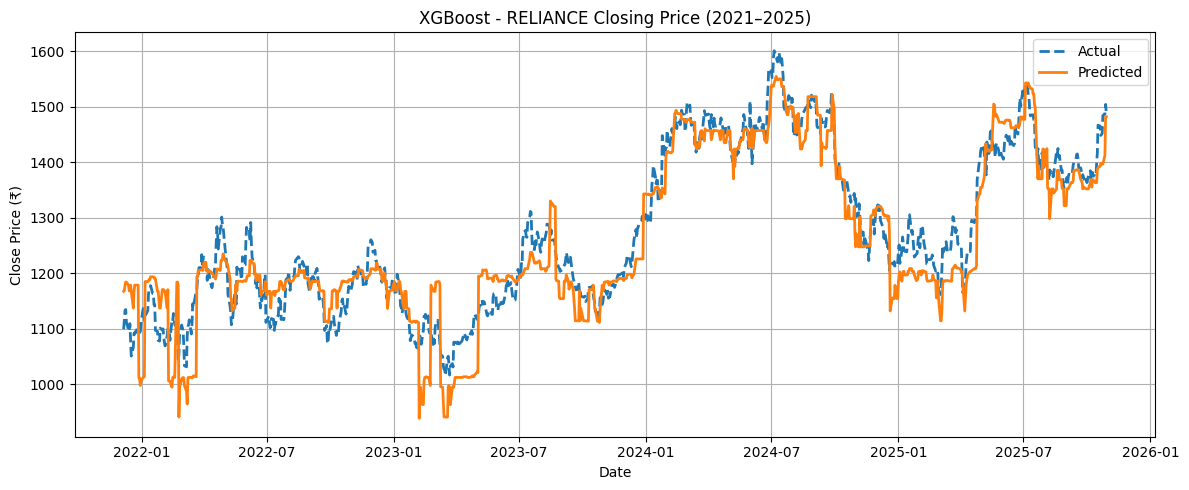


XGBoost evaluation metrics saved to: /Users/somrajbharadwaj/project/final_data_science/venv/xgboost_stock_metrics.csv

Evaluation for BHEL (2021–2025):
RMSE: 8.88
MAE: 6.36
R² Score: 0.9901


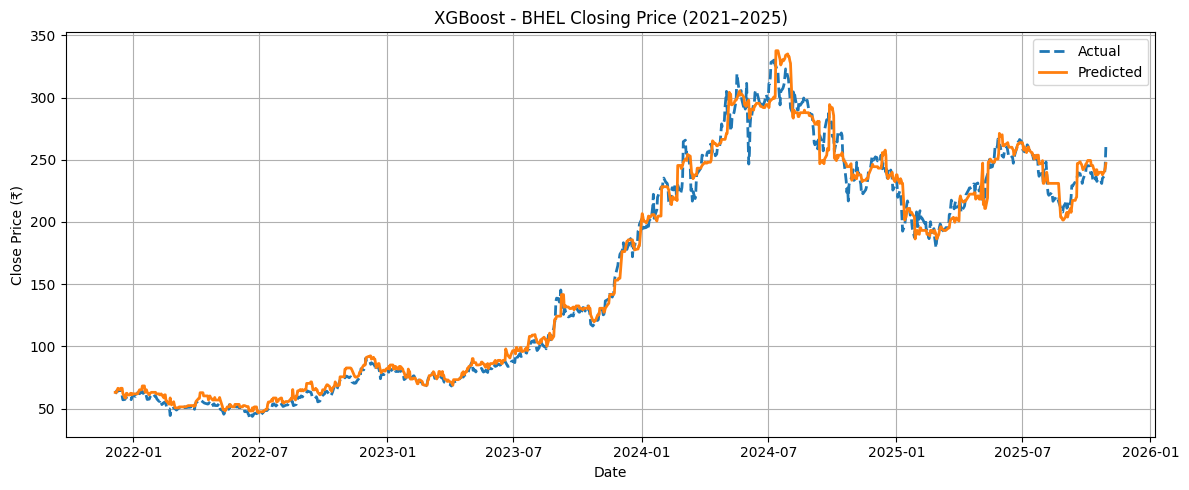


XGBoost evaluation metrics saved to: /Users/somrajbharadwaj/project/final_data_science/venv/xgboost_stock_metrics.csv

Evaluation for INFY (2021–2025):
RMSE: 69.30
MAE: 54.80
R² Score: 0.8575


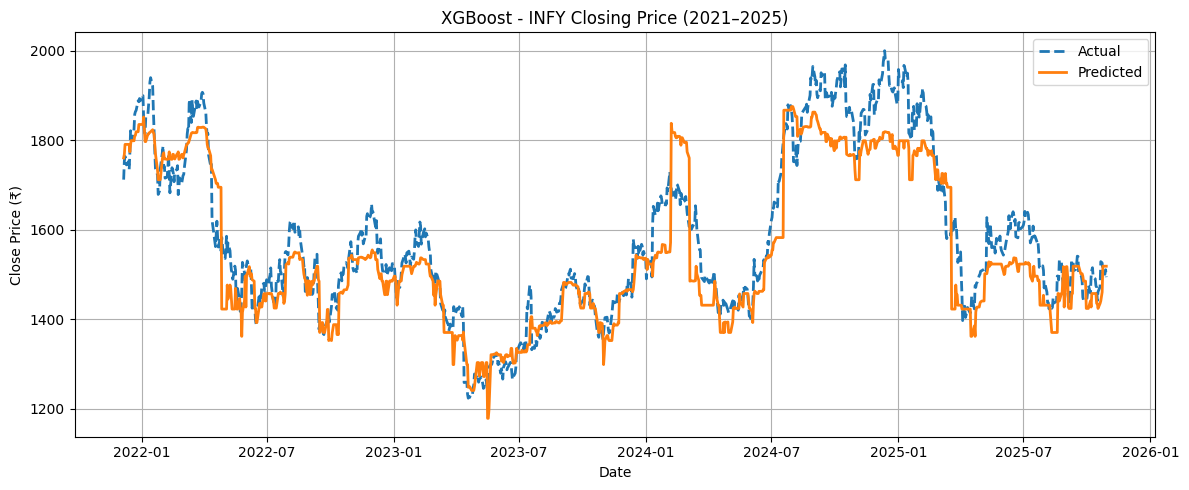


XGBoost evaluation metrics saved to: /Users/somrajbharadwaj/project/final_data_science/venv/xgboost_stock_metrics.csv


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# test dataset
test = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv")
test["Date"] = pd.to_datetime(test["Date"])

# Define features and filter time range (technical indicators)
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]
test["Target"] = test.groupby("Stock")["Close"].shift(-1)
test.dropna(subset=features + ["Target"], inplace=True)
test = test[(test["Date"] >= "2021-12-06") & (test["Date"] <= "2025-11-27")]

# best xgboost model file
xgb_model = joblib.load("/Users/somrajbharadwaj/project/final_data_science/venv/best_xgb_model_fast.pkl")

# Stocks to evaluate
selected_stocks = ["RELIANCE", "BHEL", "INFY"]

# Store evaluation metrics
metrics_list = []

for stock in selected_stocks:
    stock_df = test[test["Stock"] == stock].copy()

    if stock_df.empty:
        print(f"No data found for {stock}. Skipping...")
        continue

    X = stock_df[features]
    y_actual = stock_df["Target"]
    y_pred = xgb_model.predict(X)

    # Evaluation
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    print(f"\nEvaluation for {stock} (2021–2025):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Append metrics for saving
    metrics_list.append({
        "Stock": stock,
        "Model": "XGBoost",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # Plot
    plt.figure(figsize=(12, 5))

    # Actual values → dotted line
    plt.plot(stock_df["Date"], y_actual, label="Actual", linewidth=2, linestyle="--")

    # Predicted values → solid line
    plt.plot(stock_df["Date"], y_pred, label="Predicted", linewidth=2,)

    plt.title(f"XGBoost - {stock} Closing Price (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Close Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plot_path = f"/Users/somrajbharadwaj/project/final_data_science/venv/xgb_predicted_vs_actual_{stock.replace('.NS', '')}.png"
    plt.savefig(plot_path)
    plt.show()
    # ==========================================================
    # SAVE XGBOOST EVALUATION METRICS TO CSV
    # ==========================================================

    xgb_metrics_df = pd.DataFrame(metrics_list)

    xgb_metrics_csv = "/Users/somrajbharadwaj/project/final_data_science/venv/xgboost_stock_metrics.csv"
    xgb_metrics_df.to_csv(xgb_metrics_csv, index=False)

    print(f"\nXGBoost evaluation metrics saved to: {xgb_metrics_csv}")



Decision Tree Evaluation for HDFCBANK (2021–2025):
RMSE: 81.30
MAE : 74.63
R²  : 0.1565


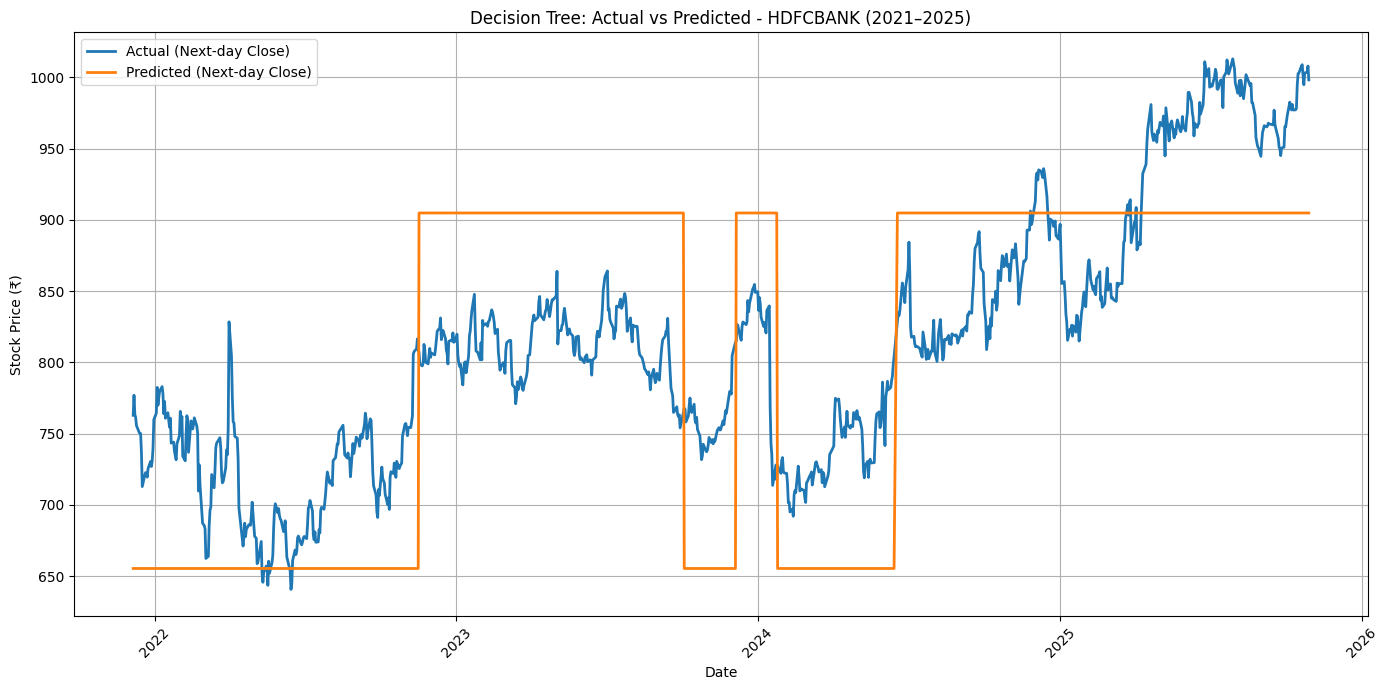

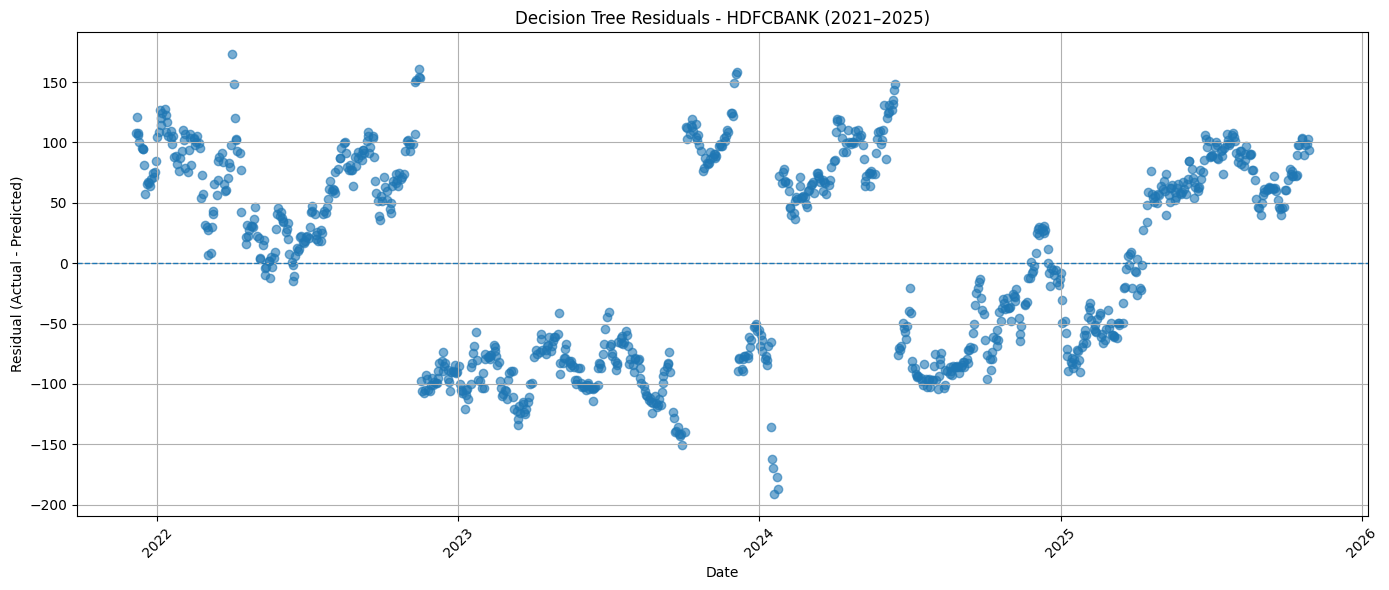


Decision Tree Evaluation for BHEL (2021–2025):
RMSE: 37.28
MAE : 29.99
R²  : 0.8250


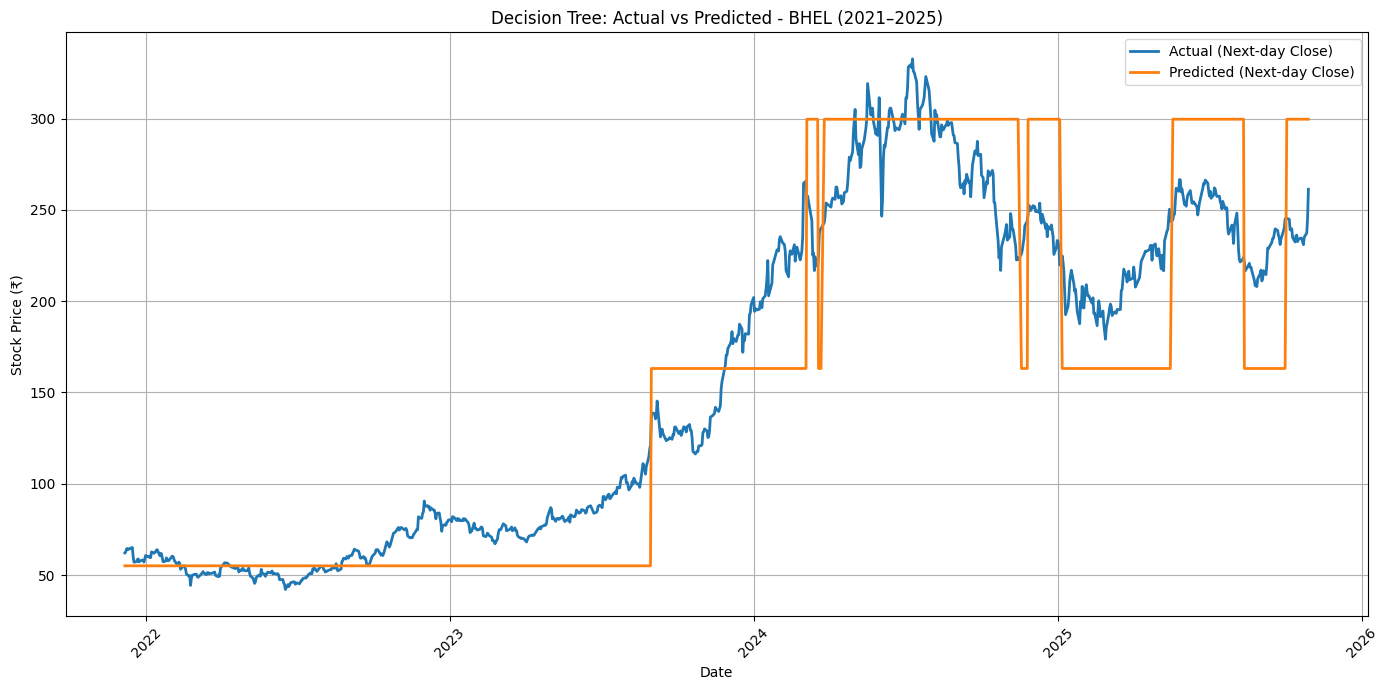

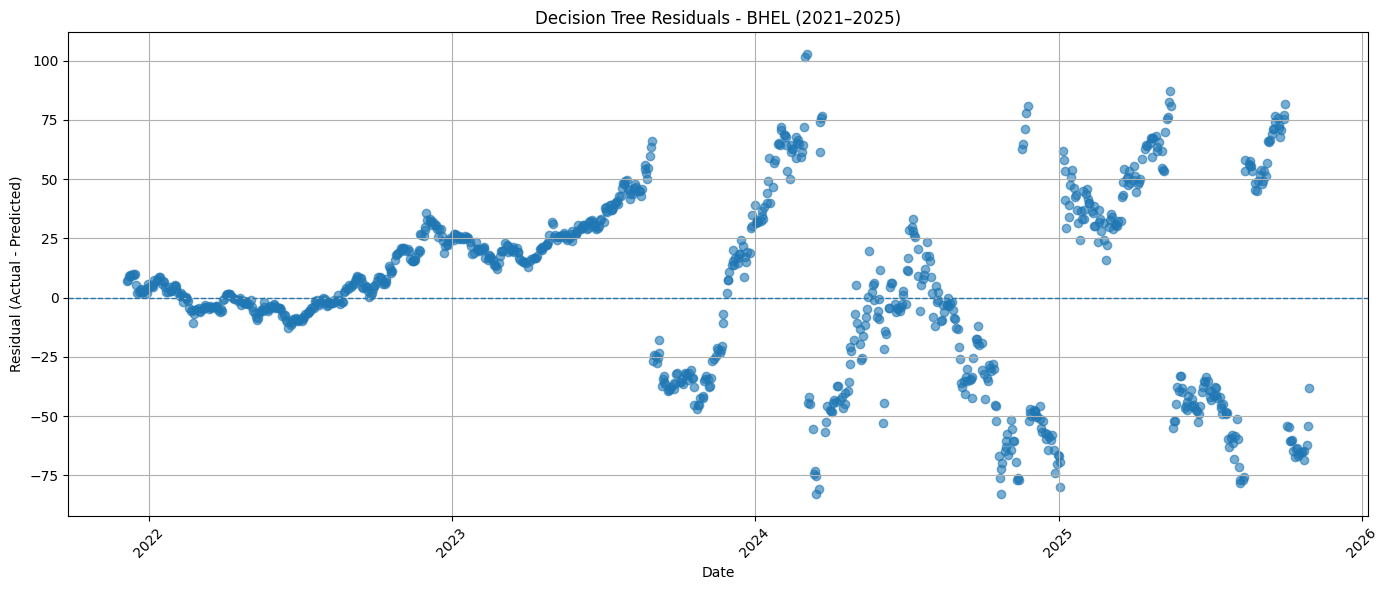


Saved Decision Tree metrics to: /Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs/decision_tree_stock_metrics.csv


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# path
train_path = "/Users/somrajbharadwaj/project/final_data_science/venv/train_80.csv"
test_path  = "/Users/somrajbharadwaj/project/final_data_science/venv/test_20.csv"

output_dir = "/Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs"
os.makedirs(output_dir, exist_ok=True)

selected_stocks = ["HDFCBANK", "BHEL"]

features = ['SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'BB_High', 'BB_Low', 'ATR_14', 'Volume_SMA_14']

# Load 
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"]  = pd.to_datetime(test_df["Date"])

# Next-day target (supervised learning)
train_df["Target"] = train_df.groupby("Stock")["Close"].shift(-1)
test_df["Target"]  = test_df.groupby("Stock")["Close"].shift(-1)

# Drop rows with missing feature/target values
train_df = train_df.dropna(subset=features + ["Target"]).copy()
test_df  = test_df.dropna(subset=features + ["Target"]).copy()


# Scale features (fit only on train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df[features])
y_train = train_df["Target"].values  # ✅ train on next-day close (Target)


# Train Decision Tree
dtree = DecisionTreeRegressor(
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dtree.fit(X_train, y_train)

# Save model + scaler
joblib.dump(dtree, os.path.join(output_dir, "decision_tree_model.pkl"))
joblib.dump(scaler, os.path.join(output_dir, "decision_tree_scaler.pkl"))

#  Evaluate per stock + plots

dt_metrics_list = []

for stock_symbol in selected_stocks:
    stock_df = test_df[test_df["Stock"] == stock_symbol].sort_values("Date").copy()

    # Filter evaluation range (2021–2025)
    stock_df = stock_df[(stock_df["Date"] >= "2021-12-06") & (stock_df["Date"] <= "2025-10-29")].copy()
    stock_df = stock_df.dropna(subset=features + ["Target"])

    if stock_df.empty:
        print(f"No valid data found for {stock_symbol} in 2021–2025. Skipping...")
        continue

    X_stock = scaler.transform(stock_df[features])
    y_actual = stock_df["Target"].values
    y_pred   = dtree.predict(X_stock)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae  = mean_absolute_error(y_actual, y_pred)
    r2   = r2_score(y_actual, y_pred)

    print(f"\nDecision Tree Evaluation for {stock_symbol} (2021–2025):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

    dt_metrics_list.append({
        "Stock": stock_symbol,
        "Model": "Decision Tree",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # Plot: Actual vs Predicted (Target = next-day close)
    plt.figure(figsize=(14, 7))
    plt.plot(stock_df["Date"], y_actual, label="Actual (Next-day Close)", linewidth=2)
    plt.plot(stock_df["Date"], y_pred, label="Predicted (Next-day Close)", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Stock Price (₹)")
    plt.title(f"Decision Tree: Actual vs Predicted - {stock_symbol} (2021–2025)")
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"dtree_actual_vs_pred_{stock_symbol}.png"))
    plt.show()

    # Residual Plot
    residuals = y_actual - y_pred
    plt.figure(figsize=(14, 6))
    plt.scatter(stock_df["Date"], residuals, alpha=0.6)
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xlabel("Date")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(f"Decision Tree Residuals - {stock_symbol} (2021–2025)")
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"dtree_residuals_{stock_symbol}.png"))
    plt.show()


#  Save metrics table
dt_metrics_df = pd.DataFrame(dt_metrics_list)
dt_metrics_csv_path = os.path.join(output_dir, "decision_tree_stock_metrics.csv")
dt_metrics_df.to_csv(dt_metrics_csv_path, index=False)

print(f"\nSaved Decision Tree metrics to: {dt_metrics_csv_path}")


      Stock          Model    RMSE     MAE  R2_Score
0  RELIANCE  Random Forest   22.07   16.81    0.9753
1      BHEL  Random Forest    5.54    3.54    0.9961
2      INFY  Random Forest   32.85   24.35    0.9680
3  RELIANCE        XGBoost   48.30   38.86    0.8814
4      BHEL        XGBoost    8.88    6.36    0.9901
5      INFY        XGBoost   69.30   54.80    0.8575
6  HDFCBANK  Decision Tree   81.49   74.82    0.1526
7      BHEL  Decision Tree   37.04   29.79    0.8273
8      INFY  Decision Tree  142.45  119.13    0.3979


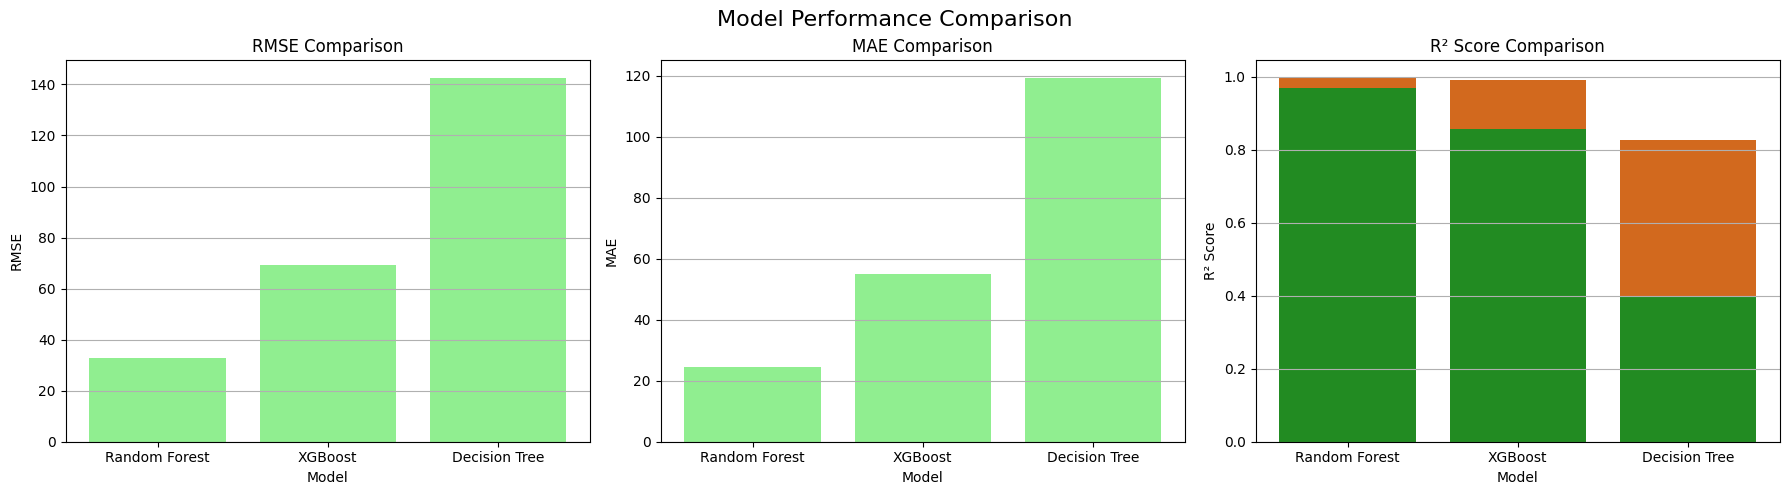

In [75]:
# Load model evaluation metrics
rf_metrics = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/random_forest_stock_metrics.csv")
xgb_metrics = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/xgboost_stock_metrics.csv")
dt_metrics = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs/decision_tree_stock_metrics.csv")

# Combine all into one dataframe
all_metrics = pd.concat([rf_metrics, xgb_metrics, dt_metrics], ignore_index=True)

# Fix R2_Score column: if R2_Score is NaN, use R2 column
# Check if 'R2' column exists before trying to fillna
if 'R2' in all_metrics.columns:
    all_metrics['R2_Score'] = all_metrics['R2_Score'].fillna(all_metrics['R2'])
    # Drop the now redundant R2 column
    all_metrics = all_metrics.drop(columns=['R2'])

# Display corrected metrics
print(all_metrics)

# Now create the combined figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot RMSE Comparison
axes[0].bar(all_metrics['Model'], all_metrics['RMSE'], color=['skyblue', 'sandybrown', 'lightgreen'])
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].grid(axis='y')

# Plot MAE Comparison
axes[1].bar(all_metrics['Model'], all_metrics['MAE'], color=['royalblue', 'sandybrown', 'lightgreen'])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y')

# Plot R² Score Comparison
axes[2].bar(all_metrics['Model'], all_metrics['R2_Score'], color=['navy', 'chocolate', 'forestgreen'])
axes[2].set_title('R² Score Comparison')
axes[2].set_ylabel('R² Score')
axes[2].set_xlabel('Model')
axes[2].grid(axis='y')

# Set overall figure title
fig.suptitle('Model Performance Comparison', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [76]:
# ---------------------------------------------
# Determine the BEST MODEL based on metrics
# ---------------------------------------------

# Best model based on lowest RMSE
best_rmse_model = all_metrics.loc[all_metrics['RMSE'].idxmin()]

# Best model based on lowest MAE
best_mae_model = all_metrics.loc[all_metrics['MAE'].idxmin()]

# Best model based on highest R² score
best_r2_model = all_metrics.loc[all_metrics['R2_Score'].idxmax()]

print("\n================ BEST MODELS ================\n")
print(f"Best Model (Lowest RMSE): {best_rmse_model['Model']}   → RMSE = {best_rmse_model['RMSE']}")
print(f"Best Model (Lowest MAE):  {best_mae_model['Model']}    → MAE  = {best_mae_model['MAE']}")
print(f"Best Model (Highest R²):  {best_r2_model['Model']}     → R²   = {best_r2_model['R2_Score']}")

# If you want ONE FINAL BEST MODEL, rank them:
# Lowest RMSE and MAE gets lower score, highest R2 gets higher score

all_metrics['Rank'] = (
    all_metrics['RMSE'].rank() +        # lower RMSE is better
    all_metrics['MAE'].rank() +         # lower MAE is better
    (-all_metrics['R2_Score']).rank()   # higher R2 is better
)

final_best_model = all_metrics.loc[all_metrics['Rank'].idxmin()]

print("\n🔥 FINAL OVERALL BEST MODEL 🔥")
print(f"Best Model: {final_best_model['Model']}")
print(final_best_model)



================ BEST MODELS ================

Best Model (Lowest RMSE): Random Forest   → RMSE = 5.54
Best Model (Lowest MAE):  Random Forest    → MAE  = 3.54
Best Model (Highest R²):  Random Forest     → R²   = 0.9961

🔥 FINAL OVERALL BEST MODEL 🔥
Best Model: Random Forest
Stock                BHEL
Model       Random Forest
RMSE                 5.54
MAE                  3.54
R2_Score           0.9961
Rank                  3.0
Name: 1, dtype: object
